In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
from io import BytesIO
%matplotlib inline

In [2]:
api_url = 'https://api.coingecko.com/api/v3/coins/{}/market_chart?vs_currency=usd&days={}&interval=daily'
headers={'Content-type':'text/plain'}

In [3]:
#global variables
price_data = {}
normalized_data = {}
log_return = {}
cryptos = []

In [20]:
def get_crypto_data(coin, days):
    json_url = api_url.format(coin, days)
    resp = requests.get(json_url)
    bjson = resp.json()
    prices = bjson["prices"]
    df_price = pd.DataFrame(prices)  
    df_price = df_price.rename({0: 'date', 1: 'price'}, axis=1)  # new method
    df_price = df_price.set_index('date')
    df_price.head();
    return df_price

In [21]:
##TEST
get_crypto_data('bitcoin', 100)

,price
date,
1657411200000,21589.628101
1657497600000,20859.814080
1657584000000,19998.467840
1657670400000,19350.737350
1657756800000,20225.238664
...,...
1665705600000,19383.943220
1665792000000,19198.107145
1665878400000,19072.780513


In [22]:
def efficientFrontier(crypto, days):
    global cryptos
    cryptos = crypto
    plotPriceComparison(crypto, days)

In [36]:
def sharpRatio():
    global log_return
    log_ret = log_return
    global normalized_data
    dfp = normalized_data
    global cryptos
    crypto = cryptos

    log_ret.describe().transpose()
    log_ret.mean() * 600
    log_ret.cov()
    num_ports = 3000
    all_weights = np.zeros((num_ports,len(dfp.columns)))
    ret_arr = np.zeros(num_ports)
    vol_arr = np.zeros(num_ports)
    sharpe_arr = np.zeros(num_ports)

    for ind in range(num_ports):
        # Create Random Weights
        weights = np.array(np.random.random(len(dfp.columns)))
        # Rebalance Weights
        weights = weights / np.sum(weights)
        # Save Weights
        all_weights[ind,:] = weights
        # Expected Return
        ret_arr[ind] = np.sum((log_ret.mean() * weights) *365)
        # Expected Variance
        vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 365, weights)))
        # Sharpe Ratio
        sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]
    sharpe_arr.max()
    sharpe_arr.argmax()

    optimal_ratio = list(all_weights[sharpe_arr.argmax(),:])
    optimal_portfolio = {}
    i = 0
    for coin in crypto:
        optimal_portfolio[coin] = str(round(optimal_ratio[i] * 100)) + '%'
        i += 1
    print('optimal-portfolio', str(optimal_portfolio)) ######

    max_sr_ret = ret_arr[sharpe_arr.argmax()]
    max_sr_vol = vol_arr[sharpe_arr.argmax()]
    maxiums = {}
    maxiums['Max_SharpeRatio_Return'] = max_sr_ret
    maxiums['Max_SharpeRatio_Volitility'] = max_sr_vol
    print('maximum-perf', str(maxiums))######

    fig, ax = plt.subplots(figsize=(7, 4))
    plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.title('Efficient Frontier: Sharpe Ratio')
    plt.scatter(max_sr_vol, max_sr_ret, c='red', s=50, edgecolors='black')
    print('sharp-ratio', fig) ######
    figdata = BytesIO()
    fig.savefig(figdata, format='png')
    figdata.getvalue()


In [25]:
def plotPriceComparison(crypto, days):
    crypto_data = {}
    for coin in crypto:
        crypto_price_df = get_crypto_data(coin, days)
        crypto_data[coin] = crypto_price_df
    dfp = pd.concat(crypto_data, axis=1)
    dfp.columns = crypto

    global price_data
    price_data = dfp

    global normalized_data
    normalized_data = dfp/dfp.iloc[0]

    crypto_daily_ret = dfp.pct_change(1)  # Daily return
    log_ret = np.log(dfp/dfp.shift(1))  #Log return

    global log_return 
    log_return = log_ret
    sharpRatio()

optimal-portfolio {'bitcoin': '100%'}
maximum-perf {'Max_SharpeRatio_Return': -0.46635504600530336, 'Max_SharpeRatio_Volitility': 0.6773530066393394}
sharp-ratio Figure(504x288)


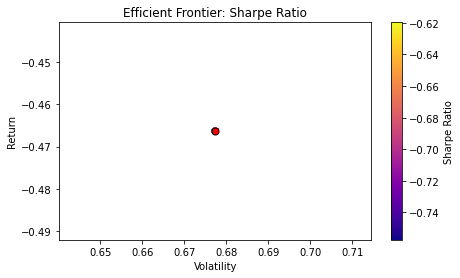

In [37]:
efficientFrontier(['bitcoin'], 500)